In [3]:
import pandas as pd
import scipy as sc
import numpy as np
import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

In [4]:
from constants import guest_types
from constants import colors
from constants import systems
from bootstrap import bootstrap
from bootstrap import dG_bootstrap
from bootstrap import dH_bootstrap
import plotting

# Load in results

In [5]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

In [6]:
bgbg["-TdS"] = bgbg["Delta G"] - bgbg["Delta H"]
bgbg["-TdS_SEM"] = np.sqrt(bgbg["G_SEM"] ** 2 + bgbg["H_SEM"] ** 2)

bg2bg2["-TdS"] = bg2bg2["Delta G"] - bg2bg2["Delta H"]
bg2bg2["-TdS_SEM"] = np.sqrt(bg2bg2["G_SEM"] ** 2 + bg2bg2["H_SEM"] ** 2)

smirnoff["-TdS"] = smirnoff["Delta G"] - smirnoff["Delta H"]
smirnoff["-TdS_SEM"] = np.sqrt(smirnoff["G_SEM"] ** 2 + smirnoff["H_SEM"] ** 2)


smirnoff_combined["-TdS"] = smirnoff_combined["Delta G"] - smirnoff_combined["Delta H"]
smirnoff_combined["-TdS_SEM"] = np.sqrt(
    smirnoff_combined["G_SEM"] ** 2 + smirnoff_combined["H_SEM"] ** 2
)

bgbg_combined["-TdS"] = bgbg_combined["Delta G"] - bgbg_combined["Delta H"]
bgbg_combined["-TdS_SEM"] = np.sqrt(
    bgbg_combined["G_SEM"] ** 2 + bgbg_combined["H_SEM"] ** 2
)

bg2bg2_combined["-TdS"] = bg2bg2_combined["Delta G"] - bg2bg2_combined["Delta H"]
bg2bg2_combined["-TdS_SEM"] = np.sqrt(
    bg2bg2_combined["G_SEM"] ** 2 + bg2bg2_combined["H_SEM"] ** 2
)

experimental["-TdS"] = experimental["Delta G"] - experimental["Delta H"]
experimental["-TdS_SEM"] = np.sqrt(
    experimental["G_SEM"] ** 2 + experimental["H_SEM"] ** 2
)


# Plot comparisons

In [53]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name, statistics_file_prefix):
    fig, ax = plt.subplots(1, figsize=(6 * 1.0, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = pd.read_csv(f"results/{statistics_file_prefix}_{typ}.csv")
        type_statistics.index = type_statistics["Unnamed: 0"]
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}  [{type_statistics['ci_low']['R**2']:0.2f}, {type_statistics['ci_high']['R**2']:0.2f}]"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0', fc="white", ec='none')
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 6)
    ax.set_xlim(-8, 6)

    statistics = pd.read_csv(f"results/{statistics_file_prefix}_overall.csv")
    statistics.index = statistics["Unnamed: 0"]
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['ci_low']['RMSE']:0.2f}, {statistics['ci_high']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['ci_low']['R**2']:0.2f}, {statistics['ci_high']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    def set_ticks(ticks):
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
    set_ticks(range(-8, 6, 2))

    
    fig.savefig(f"figures/{name}.pdf", bbox_inches="tight")
    fig.savefig(f"figures/{name}.png", dpi=300, bbox_inches="tight")    

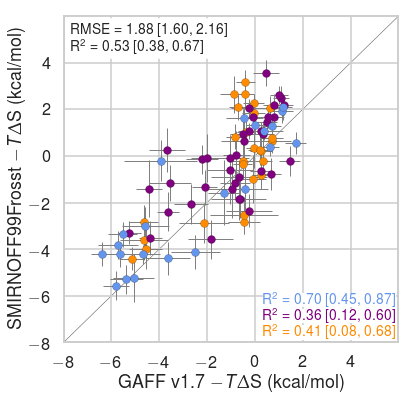

In [54]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="-TdS_bgbg_tip3p",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bgbg_tip3p",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-TdS-by-orientation",
        statistics_file_prefix="bgbg_smirnoff_by_orientation_-TdS_statistics")

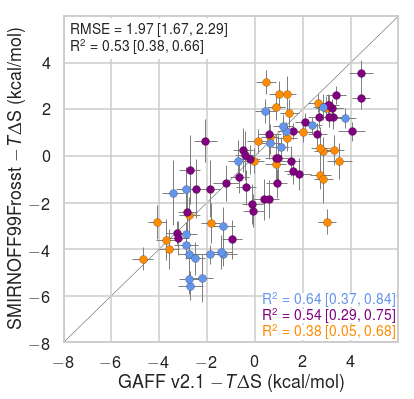

In [55]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="-TdS_bg2bg2_tip3p",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bg2bg2_tip3p",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-TdS-by-orientation",
        statistics_file_prefix="bg2bg2_smirnoff_by_orientation_-TdS_statistics")

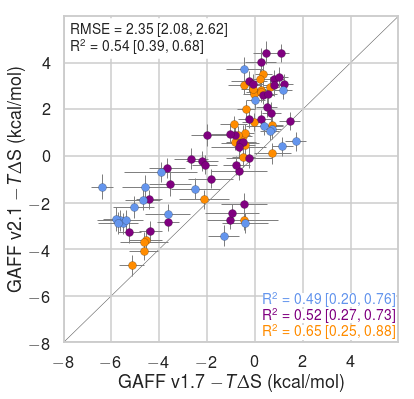

In [56]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg.merge(bg2bg2, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="-TdS_bgbg_tip3p",
        y="-TdS_bg2bg2_tip3p",
        xerr="-TdS_SEM_bgbg_tip3p",
        yerr="-TdS_SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-TdS-by-orientation",
        statistics_file_prefix="bgbg_bg2bg2_by_orientation_-TdS_statistics")

## Combined results with pre-computed statistics

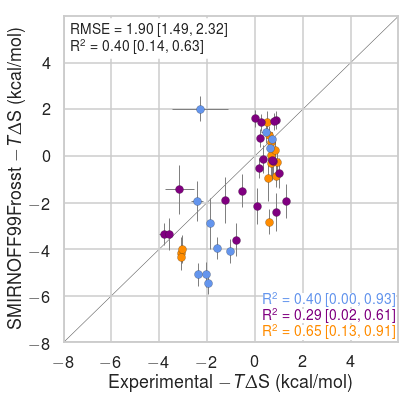

In [57]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-TdS",
        statistics_file_prefix="experimental_smirnoff_-TdS_statistics")

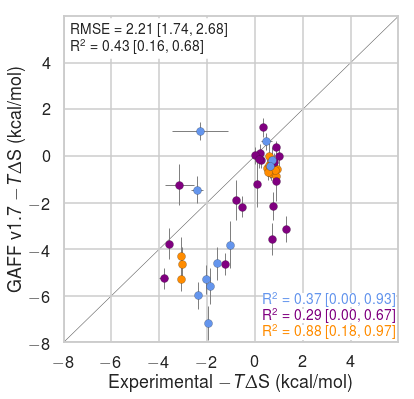

In [58]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_bgbg",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_bgbg",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-TdS",
        statistics_file_prefix="experimental_bgbg_-TdS_statistics")

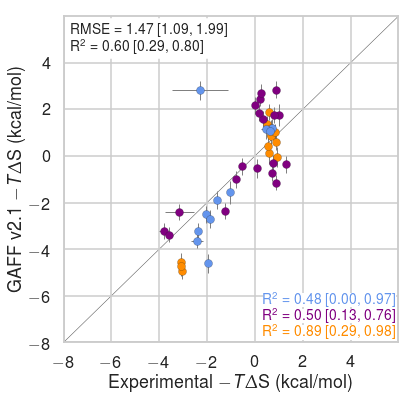

In [59]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-TdS",
        statistics_file_prefix="experimental_bg2bg2_-TdS_statistics")

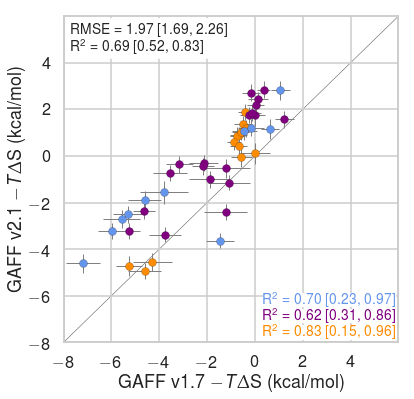

In [60]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-TdS",
        statistics_file_prefix="bgbg_bg2bg2_-TdS_statistics")

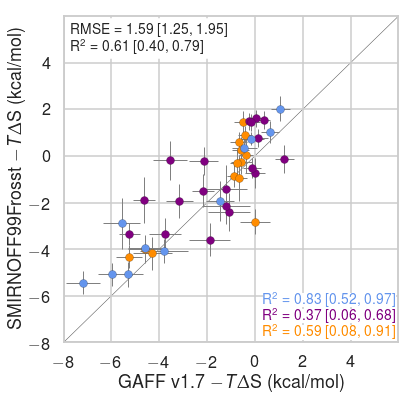

In [61]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-TdS",
        statistics_file_prefix="bgbg_smirnoff_-TdS_statistics")

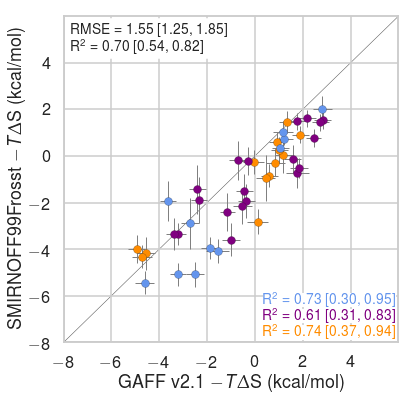

In [62]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff_combined.merge(bg2bg2_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_bg2bg2",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bg2bg2",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-TdS",
        statistics_file_prefix="bg2bg2_smirnoff_-TdS_statistics")

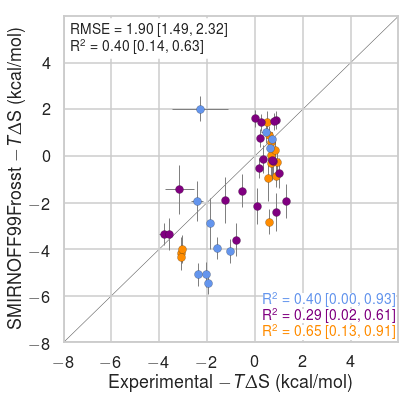

In [63]:

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="-TdS_experiment",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_experiment",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"Experimental $-T\Delta$S (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T\Delta$S (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-TdS",
        statistics_file_prefix="experimental_smirnoff_-TdS_statistics")

(-8, 6)

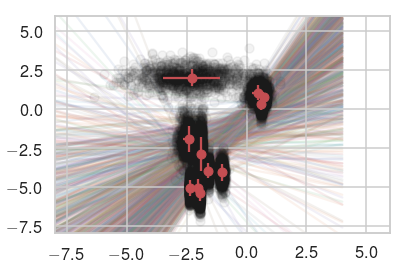

In [52]:
cycles = 1000

tmp = df[df["Type"] == "cyclic_alcohols"]

x=tmp["-TdS_experiment"]
y=tmp["-TdS_smirnoff"]
x_sem=tmp["-TdS_SEM_experiment"]
y_sem=tmp["-TdS_SEM_smirnoff"]

R_2 = np.empty((cycles))

plt.figure()
plt.errorbar(x, y, xerr=x_sem, yerr=y_sem, c="r", fmt="o", zorder=10)

for cycle in range(cycles):
    
    new_x = np.empty_like(x)
    new_y = np.empty_like(y)
    for index in range(len(x)):
        j = np.random.randint(len(x))
        new_x[index] = np.random.normal(x.iloc[j], x_sem.iloc[j])
        new_y[index] = np.random.normal(y.iloc[j], y_sem.iloc[j])
        
    plt.scatter(new_x, new_y, c="k", alpha=0.05, zorder=1)
        
    slope, intercept, r, pval, stderr = sc.stats.linregress(new_x, new_y)
    x_range = range(-8, 5)
    plt.plot(x_range, slope*x_range + intercept, alpha=0.1, zorder=0)
    R_2[cycle] = r**2
plt.xlim(-8, 6)
plt.ylim(-8, 6)

Text(0.5, 0, 'R$^2$')

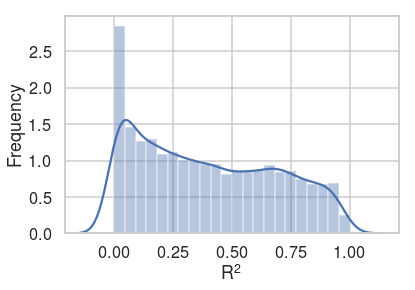

In [42]:
ax = sns.distplot(R_2)
ax.set_ylabel("Frequency")
ax.set_xlabel(r"R$^2$")

In [33]:
tmp = df[df["Type"] == "cyclic_alcohols"]


In [40]:
x.iloc[10]

-1.8899999999999997

In [43]:
colors

{'aliphatic_ammoniums': 'darkorange',
 'cyclic_alcohols': 'cornflowerblue',
 'aliphatic_carboxylates': 'purple'}

In [45]:
np.sort(R_2)

array([  5.04573170e-10,   7.99986720e-10,   3.34725824e-08, ...,
         9.88204190e-01,   9.94771866e-01,   9.97041964e-01])